# Marketing Cost for Food Supermarket

#### Requirements:
Predict the marketing media cost to acquire a new customer for a US food store, based on features such as customer income,..and store areas...<br>
(Challenge: Using Apache Spark where possible)

#### Use Case:
A US Food company is doing a marketing planning for the enxt year. They need to understand the media-marketing cost associated with acquiring a new customer in a given  store and a given state/city.  It will enable them to optimzie the cost allocation for maximized return.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Spark Setup
!pip list

In [2]:
!pip install pyspark==3.3.0

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [4]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [5]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/28 00:41:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. ETL - Data Exploration

In [6]:
# Load data from cvs file, which was sourced frim public domain
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

raw_data = pd.read_csv(wslib.mount.get_data_path('test_data.csv'))
raw_data.head()


,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4,Bag Stuffers,USA,M,F,...,18670,5415,3610,1,1,1,1,1,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3,Cash Register Lottery,USA,M,M,...,18670,5415,3610,1,1,1,1,1,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2,High Roller Savings,USA,S,F,...,18670,5415,3610,1,1,1,1,1,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2,Cash Register Lottery,USA,M,F,...,18670,5415,3610,1,1,1,1,1,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3,Double Down Sale,USA,M,M,...,18670,5415,3610,1,1,1,1,1,Radio,50.79


In [7]:
# Data types: Are data types of columns matching their content? E.g. is age stored as integer and not as string?
raw_data.dtypes

food_category                object
food_department              object
food_family                  object
store_sales(in millions)    float64
store_cost(in millions)     float64
unit_sales(in millions)       int64
promotion_name               object
sales_country                object
marital_status               object
gender                       object
total_children                int64
education                    object
member_card                  object
occupation                   object
houseowner                   object
avg_cars_at home(approx)      int64
avg. yearly_income           object
num_children_at_home          int64
brand_name                   object
SRP                         float64
gross_weight                float64
net_weight                  float64
recyclable_package            int64
low_fat                       int64
units_per_case                int64
store_type                   object
store_city                   object
store_state                 

In [8]:
raw_data.shape

(60428, 39)

In [9]:
# Data Emptiness: Are all values non-null where mandatory? E.g. client IDs
#      Null: None found, so no imputation needed
#      
raw_data.isnull().sum()

food_category               0
food_department             0
food_family                 0
store_sales(in millions)    0
store_cost(in millions)     0
unit_sales(in millions)     0
promotion_name              0
sales_country               0
marital_status              0
gender                      0
total_children              0
education                   0
member_card                 0
occupation                  0
houseowner                  0
avg_cars_at home(approx)    0
avg. yearly_income          0
num_children_at_home        0
brand_name                  0
SRP                         0
gross_weight                0
net_weight                  0
recyclable_package          0
low_fat                     0
units_per_case              0
store_type                  0
store_city                  0
store_state                 0
store_sqft                  0
grocery_sqft                0
frozen_sqft                 0
meat_sqft                   0
coffee_bar                  0
video_stor

In [10]:
# Data Uniqueness: Are duplicates present where undesired? E.g. client IDs
#       Found dup "avg car" column, removed from source
#       Can also remove via code check

raw_data = raw_data.loc[:,~raw_data.columns.duplicated()]

In [11]:
# Side NOte: More data checkups where needed, but none needed for this data set
#
#      Set memberships: Are only allowed values chosen for categorical or ordinal fields? E.g. Female, Male, Unknown
#      Foreign key set memberships: Are only allowed values chosen a field? E.g. ZIP code
#      Regular expressions: Some files need to stick to a pattern expressed by a regular expression. E.g. a lower-case character followed by 6 digits
#      Cross-field validation: Some fields can impact validity of other fields. E.g. a male person can’t be pregnant


In [12]:
raw_data['food_category'].unique()

array(['Breakfast Foods', 'Bread', 'Canned Shrimp', 'Baking Goods',
       'Vegetables', 'Frozen Desserts', 'Candy', 'Snack Foods', 'Dairy',
       'Starchy Foods', 'Cleaning Supplies', 'Decongestants', 'Meat',
       'Hot Beverages', 'Jams and Jellies', 'Carbonated Beverages',
       'Seafood', 'Specialty', 'Kitchen Products', 'Electrical',
       'Beer and Wine', 'Candles', 'Fruit', 'Pure Juice Beverages',
       'Canned Soup', 'Paper Products', 'Canned Tuna', 'Eggs', 'Hardware',
       'Canned Sardines', 'Canned Clams', 'Pain Relievers', 'Side Dishes',
       'Bathroom Products', 'Magazines', 'Frozen Entrees', 'Pizza',
       'Cold Remedies', 'Canned Anchovies', 'Drinks', 'Hygiene',
       'Plastic Products', 'Canned Oysters', 'Packaged Vegetables',
       'Miscellaneous'], dtype=object)

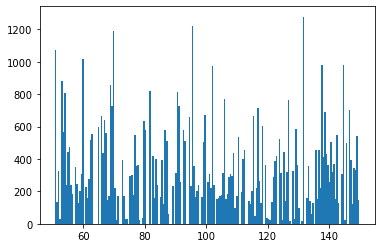

In [13]:
plt.hist(raw_data['cost'], 200)

plt.show()

In [14]:
# Data Ranges: Does the value distribution of values in a column make sense? Use stats (e.g. min,
#              max, mean, standard deviation) and visualizations (e.g. box-plot, histogram) for help
raw_data.describe()

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,net_weight,recyclable_package,...,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,...,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000
mean,6.541031,2.619460,3.093169,2.533875,2.200271,0.829351,2.115258,13.806433,11.796289,0.558665,...,27988.477494,19133.799696,5312.852552,3541.846280,0.612646,0.354157,0.587956,0.587956,0.562603,99.262366
std,3.463047,1.453009,0.827677,1.490165,1.109644,1.303424,0.932829,4.622693,4.682986,0.496551,...,5701.022090,3987.395735,1575.907263,1050.471635,0.487150,0.478261,0.492207,0.492207,0.496069,30.011257
min,0.510000,0.163200,1.000000,0.000000,0.000000,0.000000,0.500000,6.000000,3.050000,0.000000,...,20319.000000,13305.000000,2452.000000,1635.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,3.810000,1.500000,3.000000,1.000000,1.000000,0.000000,1.410000,9.700000,7.710000,0.000000,...,23593.000000,16232.000000,4746.000000,3164.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.650000
50%,5.940000,2.385600,3.000000,3.000000,2.000000,0.000000,2.130000,13.600000,11.600000,1.000000,...,27694.000000,18670.000000,5062.000000,3375.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.520000
75%,8.670000,3.484025,4.000000,4.000000,3.000000,1.000000,2.790000,17.700000,16.000000,1.000000,...,30797.000000,22123.000000,5751.000000,3834.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,22.920000,9.726500,6.000000,5.000000,4.000000,5.000000,3.980000,21.900000,20.800000,1.000000,...,39696.000000,30351.000000,9184.000000,6122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


## 2. Feature Creation and Feature Engineering

One important and noticeable issue with this set of data are the presence of both the continuous data and categorical data, totally 39 columns.

We assess them separately

### 2.1 Feature Scan: Continuous Data Columns

<AxesSubplot:>

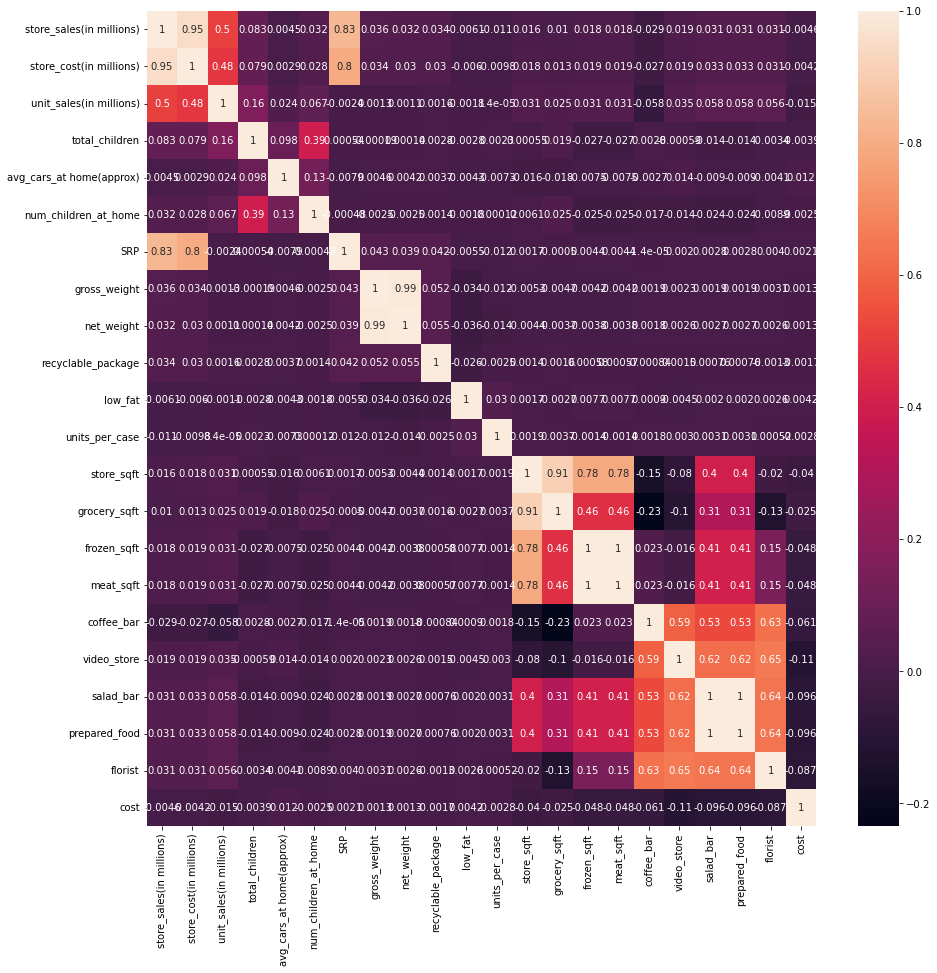

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(data=raw_data.corr(), annot=True)

In [16]:
# Two things can be learn from the above correlation heatmap:
#
# 1. Many features are actually related to each other, such that we can simplify the model by reducing the "duplicated" features 
#        that are highly correlated together:
#
#    Following are the groups of parameters that with more than 75% correlations, For each group, we will use only the first feature
#    Group 1:  store_sales(in millions) (Retain), store_cost(in millions) 95%, SRP 83%
#    Group 2:  gross_weight (Retain), net_weight 99%
#    Group 3:  store_sqft (Retain), grocery_sqft 91%, frozen_sqrt 78%, meat_sqrt 78%
#    Group 4:  salad_bar (Retain), prepared_food 100%


raw_data = raw_data.drop(columns=[ 
    'store_cost(in millions)', 'SRP',
    'net_weight', 
    'grocery_sqft', 'frozen_sqft', 'meat_sqft',
    'prepared_food', 
    ])
raw_data.columns

Index(['food_category', 'food_department', 'food_family',
       'store_sales(in millions)', 'unit_sales(in millions)', 'promotion_name',
       'sales_country', 'marital_status', 'gender', 'total_children',
       'education', 'member_card', 'occupation', 'houseowner',
       'avg_cars_at home(approx)', 'avg. yearly_income',
       'num_children_at_home', 'brand_name', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_type',
       'store_city', 'store_state', 'store_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'florist', 'media_type', 'cost'],
      dtype='object')

In [17]:
# Reset number features
numberCol_Names = raw_data.select_dtypes(include=['float64', 'int']).columns.tolist()
numberCol_Names

['store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'avg_cars_at home(approx)',
 'num_children_at_home',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
 'cost']

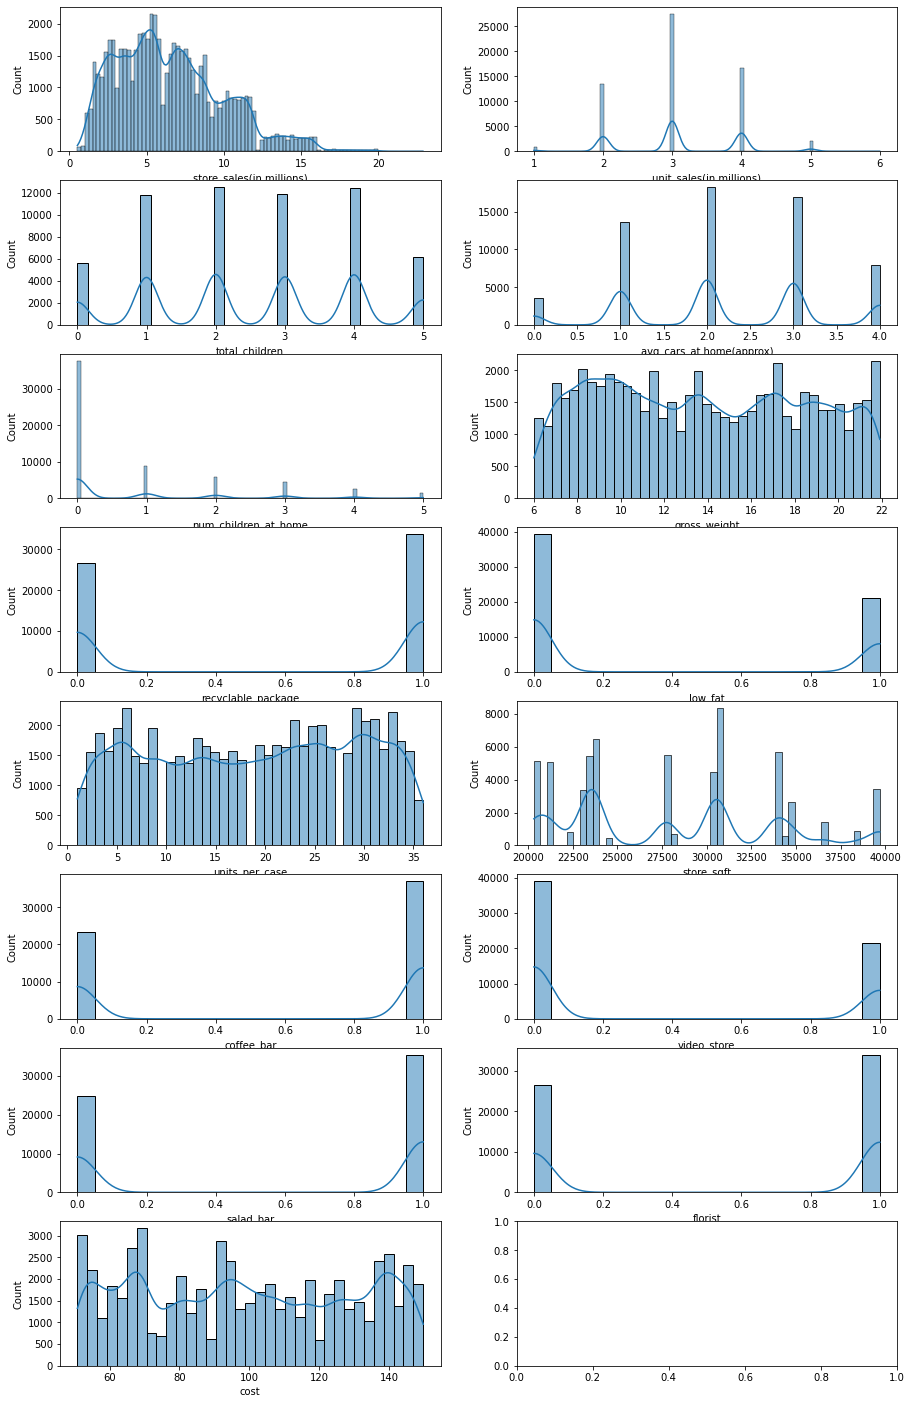

In [18]:
# Histgram plot, to identify patterns, searching for outliers
rows = 8
columns = 2
count = -1
fig, axs = plt.subplots(rows, columns, figsize=(15,25))
for col in numberCol_Names:
    count += 1
    i,j = divmod(count, columns)
    #print(i,j)
    sns.histplot(ax= axs[i, j], data=raw_data, x=numberCol_Names[count], kde=True)


In [19]:
#
# 2. None of the continuous features have a high correlation with Cost
#      Video_store (-11%), Salad_Bar (-10%), and florist (-9%), might be the ones related to Cost at highest correlation level
#      The low correlation rate unfortunately also much higher than others features, potentially can throw out a linear modeling, 
#            with too much weight on thos 10%-related parameters
#
#       To simplify the model, thinking those 3 features are alsod ecently correlated, we will take a average of them, creating a new featre call specialty_store
#  
raw_data['specialty_store'] = (raw_data['video_store'] + raw_data['salad_bar'] + raw_data['florist'])/3.0
raw_data = raw_data.drop(columns=[ 
    'video_store', 'salad_bar', 'florist',  
    ])
# Reset number features


In [20]:
# Dup features:
#
#    Remove ""# of children: and keep "children_at_home", since two are on the same aspect, while later more relevant
#
raw_data = raw_data.drop(columns=[ 
    'total_children', 
    ])

In [21]:
numberCol_Names = raw_data.select_dtypes(include=['float64', 'int']).columns.tolist()
numberCol_Names

['store_sales(in millions)',
 'unit_sales(in millions)',
 'avg_cars_at home(approx)',
 'num_children_at_home',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'cost',
 'specialty_store']

<AxesSubplot:xlabel='store_sales(in millions)', ylabel='Count'>

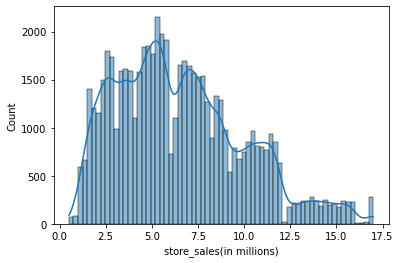

In [22]:
#    3. Outlier: Non of them show extreme outliers except the "store_sales(in millions)", will cap maximum at 17
upper_lim = 17
column = 'store_sales(in millions)'
raw_data.loc[(raw_data[column] > upper_lim),column] = upper_lim

sns.histplot(data=raw_data['store_sales(in millions)'], kde=True)

### 2.2  Feature Scan: Category Data Columns

In [23]:
categoryCol_Names = raw_data.select_dtypes(include='object').columns.tolist()
categoryCol_Names

['food_category',
 'food_department',
 'food_family',
 'promotion_name',
 'sales_country',
 'marital_status',
 'gender',
 'education',
 'member_card',
 'occupation',
 'houseowner',
 'avg. yearly_income',
 'brand_name',
 'store_type',
 'store_city',
 'store_state',
 'media_type']

In [24]:
raw_data[categoryCol_Names].describe()

,food_category,food_department,food_family,promotion_name,sales_country,marital_status,gender,education,member_card,occupation,houseowner,avg. yearly_income,brand_name,store_type,store_city,store_state,media_type
count,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428
unique,45,22,3,49,3,2,2,5,4,5,2,8,111,5,19,10,13
top,Vegetables,Produce,Food,Weekend Markdown,USA,S,F,Partial High School,Bronze,Professional,Y,$30K - $50K,Hermanos,Supermarket,Tacoma,WA,"Daily Paper, Radio"
freq,7440,8521,43284,2330,38892,30355,30942,18201,33807,19915,36510,19514,1839,26192,5704,19370,6820


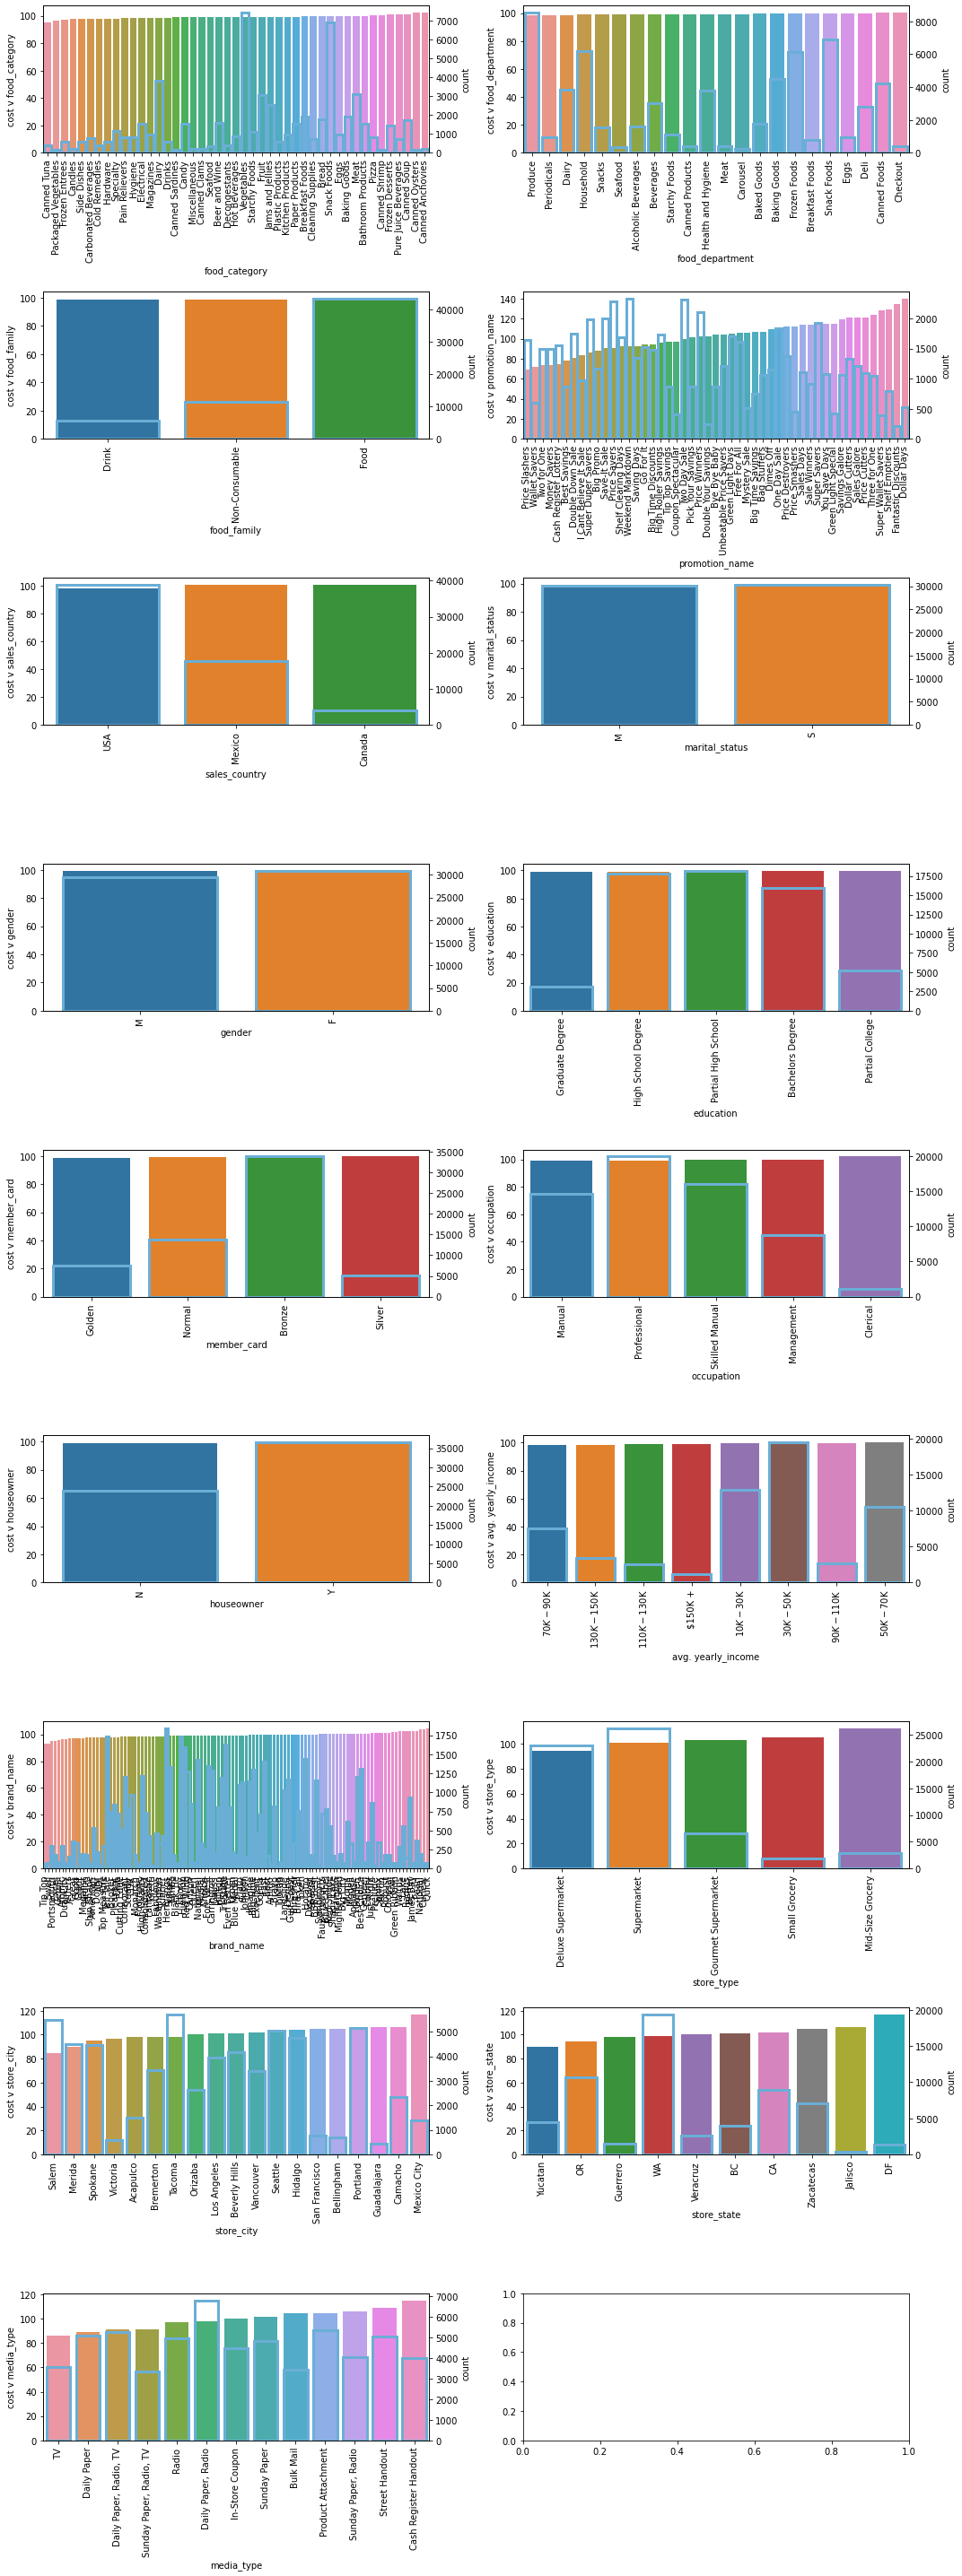

In [25]:
# Category variance vs Cost, the target data
count = -1
columns=2
fig, axs = plt.subplots(nrows=9, ncols=columns, figsize=(15,40))
for col in categoryCol_Names:
    count += 1

    i,j = divmod(count, columns)
    order = raw_data.groupby(col)['cost'].mean().sort_values().index
    
    #j = 0
    col_data = raw_data.groupby(col)['cost'].mean().sort_values().to_frame().reset_index()
    sns.barplot(ax=axs[i, j], data=col_data, x=col, y='cost', order=order)
    axs[i, j].tick_params(axis='x', rotation=90)
    axs[i, j].set_ylabel("cost v " + col)
        
    ax2 = axs[i, j].twinx()
    sns.countplot(ax= ax2, x = col, data=raw_data, order=order, facecolor=(0, 0, 0, 0),
                   linewidth=3,
                   edgecolor=sns.color_palette("Blues", 1))  #  

    
fig.tight_layout()

In [26]:
# Only a few ones show effects on the cost:
#    'promotion_name','store_type','store_city','store_state','media_type'
#
# Rest featurs will be removed from analysis
# NOTE: Not a rigrous way to de-select features, shall be testing/reject, but not going to deep on it for the scope/focsu
raw_data = raw_data.drop(columns=['food_category', 'food_department', 'food_family', 'gender', 'marital_status',
                         'brand_name', 'avg. yearly_income', 'education', 'member_card', 'houseowner', 
                          'sales_country', 'occupation'])

In [27]:
# Reset featur lists
numberCol_Names = raw_data.select_dtypes(include=['float64', 'int']).columns.tolist()
categoryCol_Names = raw_data.select_dtypes(include='object').columns.tolist()

col_list = raw_data.columns.tolist()


In [28]:
col_list = raw_data.columns.tolist()
col_list

['store_sales(in millions)',
 'unit_sales(in millions)',
 'promotion_name',
 'avg_cars_at home(approx)',
 'num_children_at_home',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_type',
 'store_city',
 'store_state',
 'store_sqft',
 'coffee_bar',
 'media_type',
 'cost',
 'specialty_store']

list_features = raw_data.columns.tolist()
list_features.remove('cost')
list_features

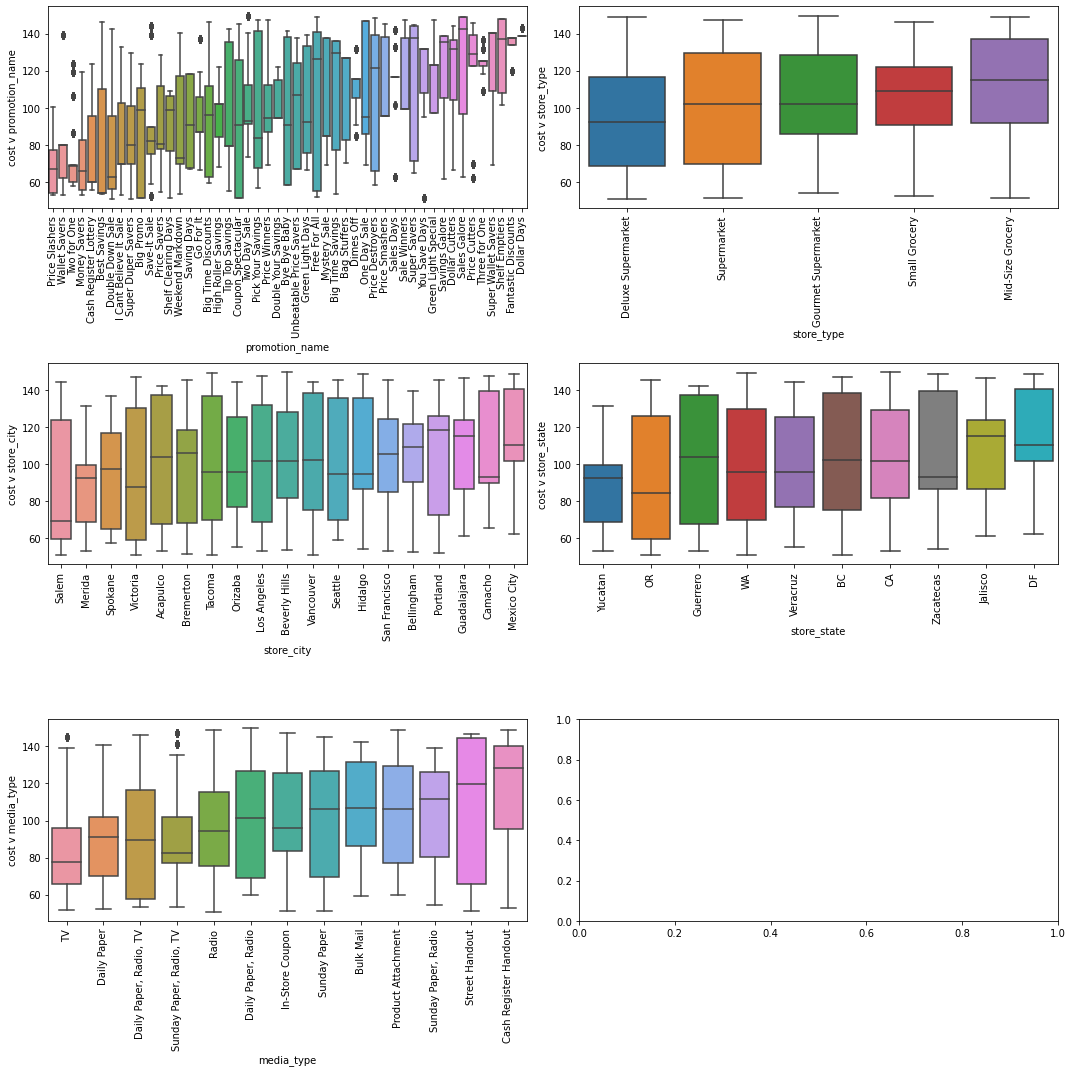

In [29]:
# Boxplot to check up for Outliers
count = -1
columns=2
fig, axs = plt.subplots(nrows=3, ncols=columns, figsize=(15,15))
for col in categoryCol_Names:
    count += 1
    i,j = divmod(count, columns)
    
    order = raw_data.groupby(col)['cost'].mean().sort_values().index
    col_data = raw_data
    sns.boxplot(ax=axs[i, j], data=col_data, x=col, y='cost', order=order)
    axs[i, j].tick_params(axis='x', rotation=90)
    axs[i, j].set_ylabel("cost v " + col) 

    
fig.tight_layout()

raw_data['store_city'].unique().tolist()

In [30]:
# Remove Outliers:
# We observed that promotion_name and media_type have outliers, especially the first one, which we like to reset

#Capping the outlier rows with Percentiles
for column in categoryCol_Names:

    for category_col in raw_data[column].unique().tolist():
        
        upper_lim = raw_data[raw_data[column]==category_col]['cost'].quantile(.90)
        lower_lim = raw_data[raw_data[column]==category_col]['cost'].quantile(.10)

        raw_data.loc[(raw_data[column]==category_col) & (raw_data['cost'] > upper_lim), 'cost'] = upper_lim
        raw_data.loc[(raw_data[column]==category_col) & (raw_data['cost'] < lower_lim), 'cost'] = lower_lim
        
        #print(column, category_col, upper_lim, max(raw_data.loc[(raw_data[column]==category_col), 'cost']))

In [31]:
data_coded = raw_data.copy(deep=True)

In [32]:
data_coded.columns

Index(['store_sales(in millions)', 'unit_sales(in millions)', 'promotion_name',
       'avg_cars_at home(approx)', 'num_children_at_home', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_type',
       'store_city', 'store_state', 'store_sqft', 'coffee_bar', 'media_type',
       'cost', 'specialty_store'],
      dtype='object')

[Not implemented] One can simplify the output class, by mapping the cost data from $50 to $150 into 11 buckets

    data_coded['class']=data_coded['cost'].apply(lambda x:(int(x//10)))
    display(data_coded['class'])

In [33]:
#One Hot Coding --> 319 feature columns (Too Many)

for ct_col in categoryCol_Names:
    one_hot_table = pd.get_dummies(raw_data[ct_col])
    data_coded = data_coded.drop(ct_col, axis=1)
    data_coded = pd.concat([data_coded, one_hot_table], axis = 1)

#### Encoding category features by OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() 
data_coded = encoder.fit_transform(raw_data[categoryCol_Names])

#### Encoding category features by OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
data_coded = encoder.fit_transform(raw_data.drop(columns='cost'))

In [34]:
data_coded.shape, raw_data.shape

((60428, 108), (60428, 17))

In [35]:
list_features = data_coded.columns.tolist()
list_features = [item for item in list_features if item != 'cost' and item != 'class']

In [36]:
len(list_features)

107

In [37]:
type(data_coded)

pandas.core.frame.DataFrame

data_coded = pd.DataFrame(data_coded.toarray())

In [38]:
# Change target data to class per dev convention
data_coded.rename(columns={'cost': 'class'}, inplace=True)

In [39]:
data_coded['class']

0        126.62
1         59.86
2         84.16
3         95.78
4         55.59
          ...  
60423     95.25
60424     70.98
60425     70.98
60426    132.88
60427     87.76
Name: class, Length: 60428, dtype: float64

### 2.3 Ready Apache Spark

In [40]:
spark_data = spark.createDataFrame(data_coded)

In [41]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = list_features, outputCol = 'features' )

In [42]:
spark_data_v = vectorAssembler.transform(spark_data)
spark_data_v = spark_data_v.select(['features', 'class'])

In [43]:
# 75% data for training
splits = spark_data_v.randomSplit([0.75, 0.25])
train_df = splits[0]
test_df = splits[1]

In [44]:
type(train_df)

pyspark.sql.dataframe.DataFrame

In [45]:
train_df.columns, train_df.count()

22/09/28 00:42:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/09/28 00:42:46 WARN TaskSetManager: Stage 0 contains a task of very large size (14642 KiB). The maximum recommended task size is 1000 KiB.


(['features', 'class'], 45245)

## 3. Model - Decision Tree Regression
###   3.1 Decision Tree Regression (Apache Spark Solution)

The Decision Tree Regression is used, mainly for two reasons:<br>
•	Its capability to incorporate both the continued data sets as well as the categorial data set, of which many presented in the source data.<br>
•	Multiple outputs, in our case, price range from $50 to $150


Additionally, there are more benefits in using this technology:<br>
•	Simple to understand the easy to interpret<br>
•	Fast to train the model (logarithmic)

In [46]:
#  Grid Search runs over two hyperparameters: maxDepth, maxBins, for Cross Validation

maxBins: Number of bins used when discretizing continuous features.

Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication. Note that the maxBins parameter must be at least the maximum number of categories M for any categorical feature.

maxDepth. Controls the maximum depth of the tree that will be created. 

It can also be described as the length of the longest path from the tree root to a leaf. The root node is considered to have a depth of 0.

In [47]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

spark.sparkContext.setLogLevel("OFF")    # Turn off warning spark WARN TaskSetManager

# Create initial Decision Tree Model
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'class')

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [40, 80])
             .build())

# Evaluate model
dt_grid_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="class", metricName="rmse")

# Define the CrossValidator
dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dt_grid_evaluator,
                      numFolds = 5)

# Run cross validations
dtcv_Model = dtcv.fit(train_df)


print(dtcv_Model)

CrossValidatorModel_bd0f2225c9b6


In [48]:
rmse_metric = dtcv_Model.avgMetrics

In [49]:
rmse_metric_sublists = [rmse_metric[i:i+2] for i in range(0, len(rmse_metric), 2)]
rmse_metric_reshape = pd.DataFrame(rmse_metric_sublists [0:], columns=['maxBins 40', 'maxBins 80'])   
rmse_metric_reshape

,maxBins 40,maxBins 80
0,25.998480,25.998480
1,25.600794,25.600794
2,23.627999,23.627999
3,20.417864,20.417864
4,14.002979,14.002979
5,7.137037,7.137037


In [50]:
param_maxDepth = [1, 2, 5, 10, 20, 30]
param_maxBins = [40, 80]

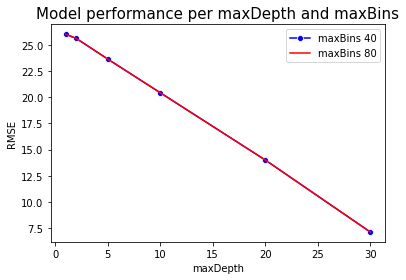

In [51]:
fig, ax = plt.subplots()

df1 = pd.DataFrame({'maxDepth':param_maxDepth,
                    'RMSE':rmse_metric_reshape['maxBins 40']})
df2 = pd.DataFrame({'maxDepth':param_maxDepth,
                    'RMSE':rmse_metric_reshape['maxBins 80']})

sns.lineplot(data=df1, x='maxDepth', y='RMSE', color="blue", marker="o", ax=ax)
sns.lineplot(data=df2, x='maxDepth', y='RMSE', color="red", ax=ax)

ax.set_title("Model performance per maxDepth and maxBins", fontsize=15)
ax.legend(["maxBins 40","maxBins 80"])

In [52]:
# Observation:
#    maxDepth: The model converge strongly per maxDepth, reducing the error from 25 to 7 level (R2 > 0.9)
#    maxBins:  Essentially has little effects on it
#

In [53]:
#  Testing Model: 
#     Use test set here so we can measure the accuracy of our model on new data
#
dt_grid_predictions = dtcv_Model.transform(test_df)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', dt_grid_evaluator.evaluate(dt_grid_predictions))

RMSE: 7.984981914782839


In [54]:
from sklearn.metrics import r2_score

eval_df = dt_grid_predictions.select('prediction', 'class').toPandas()
r2 = r2_score(eval_df.iloc[:,1], eval_df.iloc[:,0])    #   r2_score(actual, predicted)
r2

0.9098242667426167

### We achieved good accuracy in predicting the marketing cost associated with acquiring a new customer 

In [55]:
#  Discussion: 
#
#  Q: Why the convergence is slow on Spark configuration:
#  A: GBM implementations need to train models iteratively as they consider the loss of the entire ensemble when building the next tree. 
#     This makes GBM training inherently bottlenecked and not easily parallelizable (unlike random forests which are trivially parallelizable). 
#
#  Though using non-Spark technology can solve the problem as well, but the Spark challenge had been part of the specific project 

###   3.2 Gradient-boosted tree regression (Apache Spark Solution)


#####  Comparion: Boost effect

Expectations:

Improved accuracy: The straight-forward decision tress approach does not converge fast enough and ended poorly. We adopted the boosted technology to achieve optimize the modeling.

Reverse tolerance: Less pre-processing needed, in other word, more robust and effective



In [56]:
from pyspark.ml.regression import GBTRegressor
#from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#from pyspark.ml.evaluation import RegressionEvaluator

spark.sparkContext.setLogLevel("OFF")    # Turn off warning spark WARN TaskSetManager

# Create the Gradient Decision Tree Model
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'class', )


# Create ParamGrid for Cross Validation
gbtparamGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 30])   # [1, 2, 5, 10, 20, 30]
             .addGrid(dt.maxBins, [40])        # [40, 80]
             #.addGrid(gbt.maxIter, [20])
             .build())

# Evaluate model
gbt_grid_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="class", metricName="rmse")

# Define the CrossValidator
gbtcv = CrossValidator(estimator = gbt,
                      estimatorParamMaps = gbtparamGrid,
                      evaluator = gbt_grid_evaluator,
                      numFolds = 5)

# Run cross validations
gbtcv_Model = gbtcv.fit(train_df)


print(gbtcv_Model)

CrossValidatorModel_23cbd4b73880


In [57]:
rmse_metric_gbt = gbtcv_Model.avgMetrics

In [58]:
rmse_metric_gbt

[16.514695189323554, 0.9585647094839075]

In [59]:
N_maxBins = 1

rmse_metric_sublists = [rmse_metric_gbt[i:i+N_maxBins] for i in range(0, len(rmse_metric_gbt), N_maxBins)]
rmse_metric_reshape_gbt = pd.DataFrame(rmse_metric_sublists [0:], columns=['RMSE'])   
rmse_metric_reshape_gbt

,RMSE
0,16.514695
1,0.958565


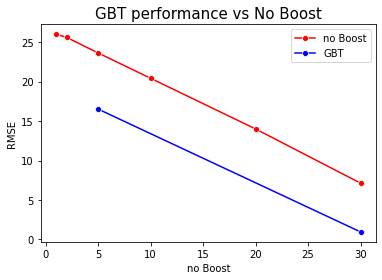

In [61]:
fig, ax = plt.subplots()

df1 = pd.DataFrame({'no Boost':param_maxDepth,
                    'RMSE':rmse_metric_reshape['maxBins 40']})
df2 = pd.DataFrame({'GBT':[5, 30],
                    'RMSE':rmse_metric_gbt})

sns.lineplot(data=df1, x='no Boost', y='RMSE', color="red", marker="o", ax=ax)
sns.lineplot(data=df2, x='GBT', y='RMSE', color="blue", marker="o", ax=ax)

ax.set_title("GBT performance vs No Boost", fontsize=15)
ax.legend(["no Boost","GBT"])

In [62]:
# Observation:
#    1. GBT runs much more steps (>33K)then the w/o boost case. taking much longer time
#    2. Accuracy ndeed im[proved for the tarining part, RMSE reduced from 7.4 to 0.8 for maxDepth = 30
#                

In [63]:
#  Testing Model: 
#     Use test set here so we can measure the accuracy of our model on new data
#
gbt_grid_predictions = gbtcv_Model.transform(test_df)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', gbt_grid_evaluator.evaluate(gbt_grid_predictions))

RMSE: 0.9221981503477785


In [64]:
#from sklearn.metrics import r2_score

eval_df_gbt = gbt_grid_predictions.select('prediction', 'class').toPandas()
r2 = r2_score(eval_df_gbt.iloc[:,1], eval_df_gbt.iloc[:,0])    #   r2_score(actual, predicted)
r2

0.9987972086327384

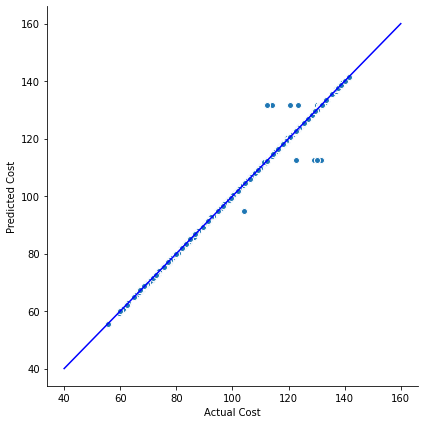

In [65]:
# Answers to the questions defined in the Usecase: Predict the marketing Cost
#
#plt.figure(figsize=(5,5))
data_plot = pd.DataFrame({"Predicted Cost":eval_df_gbt.iloc[:,1], "Actual Cost":eval_df_gbt.iloc[:,0]})
#sns.lineplot("Predicted Cost", y = "Actual Cost", data=data_plot)

X_plot = np.linspace(40, 160, 100)
Y_plot = X_plot

g = sns.FacetGrid(data_plot, height = 6)
g = g.map(plt.scatter, "Actual Cost", "Predicted Cost", edgecolor="w")
plt.plot(X_plot, Y_plot, color='b')
plt.show()

In [66]:
#  Discussion: 
#
#  A quite close turn-out for the marking cost prediciotn, show good results for testing data set
#

## 4. Resaerch on other Models for Comparison

### 4.1 Reference Model - Linear Regression (For Comparison Only, Apache Spark Solution)


To verify a conjecture that we identified during the data cleansing and feature creation. 

It's noticed that the target class, i.e., the cost, in general has quite low correlations to all numerical features. Making it worse, some features do have about 10% low level correlation, but stands out to others at 0% levels. We guessed that those parameters may leading to out-weighted prediction effect in a linear regression model. Making it worst, all of these parameters are really binary data sets (0, 1), making the linear interpretation even more challenged.


In [68]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(featuresCol = 'features', labelCol='class', maxIter=20, regParam=0.01, elasticNetParam=0.1)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.041114536675185324,-0.012285282132717493,0.42998143397451577,-0.0018147286895778523,0.010603341361786077,-0.38592114059522725,-0.031568700309507355,0.010801908127432655,-0.00012545811940786132,-1.0548510487478588,-2.4712914508893573,19.018661232694,-16.43104626258258,-10.68128595655898,-1.956637785840938,12.080131972038298,1.303306499974692,-12.823562201193836,0.028292413771554777,15.034542058532411,18.664397100703678,40.6615271574744,-13.045556229230447,-0.798605838293005,34.98931310268232,3.437558790692488,-5.349052630661258,3.628041491382258,13.478303634670361,2.312335795743048,-11.35283642798715,-22.130603327682792,7.132858355921152,12.80089710199189,1.6669153365917608,12.217130997891946,2.9331273672719864,-13.006632084957523,-35.575667128717726,1.519715569670036,0.22422738718133442,22.094908464053855,24.45636476745667,21.867532159185536,-3.9597324534441194,-9.300391505846177,11.07083289573392,-5.005967033060566,27.683483655923464,-14.221892626725946,2.048985279053

In [69]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 20.459082
r2: 0.401856


In [70]:
train_df.describe().show()

+-------+------------------+
|summary|             class|
+-------+------------------+
|  count|             45245|
|   mean| 99.04059741406778|
| stddev|26.453794813057065|
|    min|             55.59|
|    max|            141.38|
+-------+------------------+



In [71]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","class","features").show(5)


lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="class",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------+--------------------+
|        prediction| class|            features|
+------------------+------+--------------------+
|  104.852031416846|126.62|(107,[0,1,2,3,4,5...|
|104.73768007443533|126.62|(107,[0,1,2,3,4,5...|
|105.14745949436205|126.62|(107,[0,1,2,3,4,5...|
|105.55700203051315|126.62|(107,[0,1,2,3,4,5...|
|104.96636663322698|126.62|(107,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



R Squared (R2) on test data = 0.406513


In [72]:
# The poor accuracy largely for two reasons:
#
#  1. The presence of low correlated numerical features, which played a out-weighted role, skewed the linear regression
#         For example, some coefficient are as large as 18, not well conatined
#
#  2. The presence of too many category features, which the linear regression not picked up well.
#

### 4.2 Reference Model - Deep Learning - Keras (For Comparison Only)

For this supervised machine learning task, we like to implement a deep learning model for comparison purpose. Especially, we would like to measure the accuracy of it vs other models we implemented. 

In [73]:
# split the data into train and test set
from sklearn. model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_coded[list_features], data_coded['class'])  # 75% / 30%  #, test_size=0.2, random_state=42, shuffle=True)

In [74]:
X_train.shape, y_train.shape

((45321, 107), (45321,))

In [75]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

In [76]:
model = Sequential()

model.add(Dense(64, input_shape=(107,), activation='relu'))        #  'sigmoid'    
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss= 'mean_squared_error',   #  'categorical_crossentropy',  #     #  
              metrics=['mean_squared_error'])

In [77]:
import time

time_start = time.perf_counter()
model.fit(X_train, y_train, 
          epochs=1200, 
          #steps_per_epoch=708,    # default to the number of samples (45321) in your dataset divided by the batch size
          verbose=0)              # callbacks=less_verbose_callbacks)
time_end = time.perf_counter()  

print(f"Model fitting took {time_end-time_start:.2f} seconds")


Model fitting took 3819.31 seconds


In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6912      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,969
Trainable params: 7,969
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
print('r2 score: ', r2_score(y_test, y_pred))

r2 score:  0.9181746766356592


In [80]:
import math

score = model.evaluate(X_test, y_test, verbose=0)
print('mean_squared_error:',score[1], ' RMSE: ',math.sqrt(score[1]))

mean_squared_error: 57.169681549072266  RMSE:  7.561063519708869


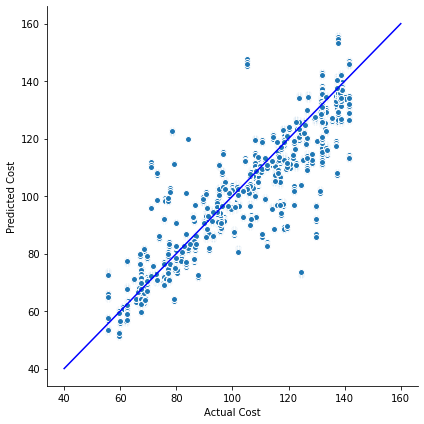

In [81]:
#test_predictions = dnn_model.predict(test_features).flatten()

data_plot = pd.DataFrame({"Predicted Cost":y_pred.flatten(), "Actual Cost":y_test})
#sns.lineplot("Predicted Cost", y = "Actual Cost", data=data_plot)

X_plot = np.linspace(40, 160, 100)
Y_plot = X_plot

g = sns.FacetGrid(data_plot, height = 6)
g = g.map(plt.scatter, "Actual Cost", "Predicted Cost", edgecolor="w")
plt.plot(X_plot, Y_plot, color='b')
plt.show()